In [79]:
# import helper
import pandas as pd
from utils import *

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from IPython.display import Image

import torch
from torch import nn
from torch.utils.data import Dataset
import pennylane as qml
import torch.optim as optim
import torch.utils.data as data
import random
import tensorflow as tf

In [80]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':20})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

## Data

First, we read in the data, dropping the index and the date.

In [81]:
df = pd.read_csv('dataset_FTSE_prediction_v1.csv')
df = df.drop([ 'Unnamed: 0'], axis=1)
df=df.drop(columns=['ARIMA'])
df=df[800:]

We identify the dependent and independent variables:

In [82]:
target = "Close"

In [83]:
features = list(df.columns.difference(["Close"]))
features

['Adj Close',
 'BBB_20_2.0',
 'BBL_20_2.0',
 'BBM_20_2.0',
 'BBP_20_2.0',
 'BBU_20_2.0',
 'CUMLOGRET_1',
 'Close_copy',
 'Crude Futures',
 'EMA_10',
 'EMA_20',
 'EMA_50',
 'FT3',
 'FT6',
 'FT9',
 'GBP USD ',
 'Gold in USD',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'SMA_10',
 'SMA_20',
 'SMA_50',
 'Volume']

In [84]:
len(features)

24

## Data processing for time series model

In [85]:
torch.manual_seed(42)
random.seed(42)

Next, in order to ensure that some values due to their mangnitude do not inherently dominate the features, we standardize their values.

In [86]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [87]:
df

,Adj Close,BBB_20_2.0,BBL_20_2.0,BBM_20_2.0,BBP_20_2.0,BBU_20_2.0,CUMLOGRET_1,Close,Crude Futures,EMA_10,...,GBP USD,Gold in USD,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_10,SMA_20,SMA_50,Volume,Close_copy
800,-0.664382,-0.518756,-0.212867,-0.376660,-2.096023,-0.541526,-0.618721,-0.664382,1.732245,-0.477768,...,2.765372,-0.923083,-0.285174,-0.957418,0.029832,-0.442130,-0.376660,-0.460099,0.479939,-0.664382
801,-0.646763,-0.405198,-0.255201,-0.392525,-1.648446,-0.526270,-0.600796,-0.646763,1.732245,-0.510207,...,2.765372,-0.947383,-0.387140,-1.015113,-0.059456,-0.471115,-0.392525,-0.463963,-0.746811,-0.646763
802,-0.651849,-0.315221,-0.292326,-0.409164,-1.448674,-0.518568,-0.605967,-0.651849,1.742954,-0.537690,...,2.671345,-0.935746,-0.466173,-1.005142,-0.147868,-0.500101,-0.409164,-0.467120,-0.835320,-0.651849
803,-0.695260,-0.219031,-0.333231,-0.428391,-1.458203,-0.511942,-0.650199,-0.695260,1.607479,-0.568214,...,2.671345,-0.959704,-0.550693,-1.010594,-0.236759,-0.531275,-0.428391,-0.473782,0.314693,-0.695260
804,-0.813687,-0.091393,-0.390878,-0.457822,-1.732959,-0.507468,-0.771680,-0.813687,1.580170,-0.615116,...,2.671345,-0.945671,-0.686218,-1.139791,-0.336992,-0.572362,-0.457822,-0.483073,-0.020605,-0.813687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134,0.764009,-0.149978,0.687472,0.738442,0.156114,0.753486,0.755674,0.764009,1.389541,0.775099,...,-0.713624,1.462017,-0.279086,0.658465,-0.531071,0.759355,0.738442,0.919877,-1.255627,0.764009
3135,0.792344,-0.320354,0.718714,0.721971,0.421769,0.683547,0.781440,0.792344,1.353128,0.781322,...,-0.807650,1.459964,-0.237484,0.628980,-0.476021,0.779237,0.721971,0.918719,-1.228554,0.792344
3136,0.858642,-0.360917,0.725812,0.717688,0.821349,0.666530,0.841517,0.858642,1.392218,0.798688,...,-0.807650,1.463044,-0.160380,0.692283,-0.415414,0.804912,0.717688,0.916662,-0.521709,0.858642
3137,0.892608,-0.370429,0.727517,0.716729,1.019851,0.662588,0.872183,0.892608,1.391683,0.819186,...,-0.807650,1.479814,-0.076886,0.758568,-0.348987,0.834026,0.716729,0.915488,-0.821082,0.892608


In [88]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
def cal_metrics(y_true,y_pred):
    mae=0
    rmse=0
    for i in range(len(y_true)):
        y1=y_true[i].flatten().numpy()* target_stdev + target_mean
        y2=y_pred[i].flatten()* target_stdev + target_mean
        mae=mean_absolute_error(y1, y2)+mae
        rmse=mean_squared_error(y1, y2, squared=False)+rmse  
    return mae/len(y_true) , rmse/len(y_true)

In [89]:
# Data for regression model
sequence_length_reg = window_reg =20 # Number of time steps that will be inputted into LSTM network

def create_dataset_reg(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,5):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback:i+lookback+window]
        X_store.append(X)
        y_store.append(y)
    return X_store,y_store

X_reg,y_reg = create_dataset_reg(
    df,
    target=target,
    features=features,
    lookback=sequence_length_reg, window=window_reg)

print(np.array(X_reg).shape, np.array(y_reg).shape)

(460, 20, 24) (460, 20)


In [90]:
indices = tf.range(start=0, limit=tf.shape(X_reg)[0])
shuffled_indices = tf.random.shuffle(indices)

In [91]:
X_reg = tf.gather(X_reg, shuffled_indices)
y_reg = tf.gather(y_reg, shuffled_indices)

In [92]:
# Train test split
m=np.array(X_reg).shape[0] # get first dimension
size=int(m*0.9)
X_train_reg=X_reg[:size]
y_train_reg=y_reg[:size]
X_test_reg=X_reg[size:]
y_test_reg=y_reg[size:]
print('Shape of train is',np.array(X_train_reg).shape,'and',np.array(y_train_reg).shape)
print('Shape os test is',np.array(X_test_reg).shape,'and',np.array(y_test_reg).shape)

Shape of train is (414, 20, 24) and (414, 20)
Shape os test is (46, 20, 24) and (46, 20)


In [93]:
X_train_reg_=np.array([inner for outer in X_train_reg for inner in outer])
print(X_train_reg_.shape)
y_train_reg_=np.array([inner for outer in y_train_reg for inner in outer])
print(y_train_reg_.shape)

(8280, 24)
(8280,)


In [94]:
X_test_reg_=np.array([inner for outer in X_test_reg for inner in outer])
print(X_test_reg_.shape)
y_test_reg_=np.array([inner for outer in y_test_reg for inner in outer])
print(y_test_reg_.shape)

(920, 24)
(920,)


In [95]:
# Prepare test data
X_check_reg=(df[features].values)[len(df)-window_reg-sequence_length_reg:len(df)- window_reg]
y_check_reg=(df[target].values)[len(df)-window_reg:len(df)]

In [96]:
X_check_reg

array([[ 1.05844214, -0.19716968,  0.75959957,  0.80516313,  1.21592729,
         0.81014498,  1.0208129 ,  1.05844214,  0.79302159,  0.8132752 ,
         0.85160002,  1.05832725, -0.80714765, -0.40596154,  0.00628931,
        -0.33751597,  1.66531029, -0.46132203,  1.0267621 , -0.85619257,
         0.69737467,  0.80516313,  1.07490531,  0.33719206],
       [ 1.16360979, -0.07160229,  0.73748563,  0.81858003,  1.46921145,
         0.86331144,  1.11414635,  1.16360979,  0.80266014,  0.88129793,
         0.88581386,  1.06690863, -0.81716517, -0.42146188, -0.01617262,
        -0.43154287,  1.63382382, -0.19384604,  1.47645234, -0.7267417 ,
         0.7646153 ,  0.81858003,  1.07164371, -0.57175877],
       [ 1.19557785,  0.06292609,  0.71762843,  0.83736927,  1.37200998,
         0.92509087,  1.14237711,  1.19557785,  0.87923305,  0.94287189,
         0.91992414,  1.07651383, -0.82718633, -0.43698916, -0.03872802,
        -0.43154287,  1.62013404,  0.03791227,  1.74878423, -0.57338238,
  

In [97]:
y_check_reg

array([0.63831643, 0.55349209, 0.46666974, 0.45831446, 0.48192723,
       0.57220067, 0.59599508, 0.60507692, 0.60507692, 0.83466572,
       0.85046811, 0.78762181, 0.83375753, 0.81250604, 0.78544217,
       0.76400904, 0.79234436, 0.85864176, 0.89260783, 0.89260783])

## ANN

In [98]:
from tensorflow.keras import regularizers, initializers
from keras.layers import Input, Dense, Reshape, Embedding, concatenate, Dropout, Flatten
from keras.layers.merge import Dot
from keras.preprocessing import sequence
from keras import Model

In [99]:
input_ = Input((len(features),)) # feature

den1=Dense(256, use_bias=True,activation='relu')(input_)

den2=Dense(128, use_bias=True,activation='relu')(den1)

den3=Dense(64, use_bias=True,activation='relu')(den2)

den4=Dense(32, use_bias=True,activation='relu')(den3)

den5=Dense(1, use_bias=True,activation='linear')(den4)

model = Model(inputs=[input_], outputs=den5)

In [100]:
import tensorflow as tf

In [101]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(opt, loss=loss_fn)

In [102]:
model_history = model.fit(X_train_reg_, y_train_reg_,
                    validation_data=(X_test_reg_, y_test_reg_),
                   batch_size=32, 
                   epochs=300, shuffle=True
                   )

Epoch 1/300
259/259 [==============================] - 1s 2ms/step - loss: 0.1452 - val_loss: 0.0729
Epoch 2/300
259/259 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0432
Epoch 3/300
259/259 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0359
Epoch 4/300
259/259 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0273
Epoch 5/300
259/259 [==============================] - 0s 2ms/step - loss: 0.0264 - val_loss: 0.0227
Epoch 6/300
259/259 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0203
Epoch 7/300
259/259 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0294
Epoch 8/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0197 - val_loss: 0.0277
Epoch 9/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0212 - val_loss: 0.0156
Epoch 10/300
259/259 [==============================] - 0s 2ms/step - loss: 0.0163 - val_lo

259/259 [==============================] - 1s 4ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 82/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 83/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 84/300
259/259 [==============================] - 1s 5ms/step - loss: 0.0031 - val_loss: 0.0032- ETA: 0s - l
Epoch 85/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 0.0055
Epoch 86/300
259/259 [==============================] - 1s 4ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 87/300
259/259 [==============================] - 1s 4ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 88/300
259/259 [==============================] - 1s 4ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 89/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 90/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0032

259/259 [==============================] - 1s 3ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 161/300
259/259 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 162/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 163/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 164/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 165/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 166/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 167/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 168/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 169/300
259/259 [==============================] - 1s 2ms/step - loss: 0.0012 - v

Epoch 239/300
259/259 [==============================] - 1s 2ms/step - loss: 7.6025e-04 - val_loss: 9.7752e-04
Epoch 240/300
259/259 [==============================] - 1s 3ms/step - loss: 7.5684e-04 - val_loss: 0.0017
Epoch 241/300
259/259 [==============================] - 1s 3ms/step - loss: 9.2089e-04 - val_loss: 0.0011
Epoch 242/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 243/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 244/300
259/259 [==============================] - 1s 3ms/step - loss: 7.1910e-04 - val_loss: 0.0010
Epoch 245/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0034.001
Epoch 246/300
259/259 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 247/300
259/259 [==============================] - 1s 3ms/step - loss: 6.2389e-04 - val_loss: 0.0011
Epoch 248/300
259/259 [======================

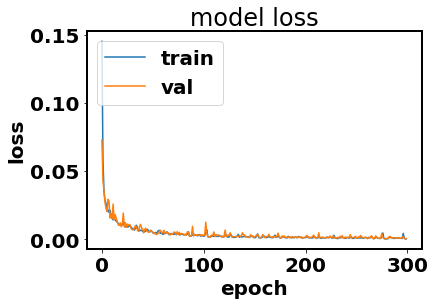

In [103]:
import keras
from matplotlib import pyplot as plt
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [104]:
def mae_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += abs(predicted[i] - actual[i])
    return sum_error/len(actual)

def rmse_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += (predicted[i] - actual[i])**2
    return (sum_error/len(actual))**0.5
    

In [105]:
# Predict the model 
y_train_pred_ann = model.predict(X_train_reg_) 
mae_train_ann = mean_absolute_error(y_train_reg_* target_stdev + target_mean, y_train_pred_ann* target_stdev + target_mean)
print('MAE train: ',mae_train_ann)
rmse_train_ann = mean_squared_error(y_train_reg_* target_stdev + target_mean, y_train_pred_ann* target_stdev + target_mean, squared=False)
print('RMSE train: ',rmse_train_ann)

MAE train:  7.639510256265097
RMSE train:  10.666194652312178


In [106]:
# Predict the model 
y_test_pred_ann = model.predict(X_test_reg_) 
mae_test_ann = mean_absolute_error(y_test_reg_* target_stdev + target_mean, y_test_pred_ann* target_stdev + target_mean)
print('MAE test: ',mae_test_ann)
rmse_test_ann = mean_squared_error(y_test_reg_* target_stdev + target_mean, y_test_pred_ann* target_stdev + target_mean, squared=False)
print('RMSE test: ',rmse_test_ann)

MAE test:  8.403280082370937
RMSE test:  12.775099259365964


In [107]:
y_check_pred_nn = model.predict(X_check_reg)
y_check_pred_nn=y_check_pred_nn.flatten()
mae_check_nn = mean_absolute_error(y_check_reg* target_stdev + target_mean, y_check_pred_nn* target_stdev + target_mean)
print('Mean absolute Error : ',mae_check_nn)
rmse_check_nn = mean_squared_error(y_check_reg* target_stdev + target_mean, y_check_pred_nn* target_stdev + target_mean, squared=False)
print('Root Mean Squared Error : ',rmse_check_nn)

Mean absolute Error :  19.249028320312345
Root Mean Squared Error :  41.4174906056258


In [108]:
window

24

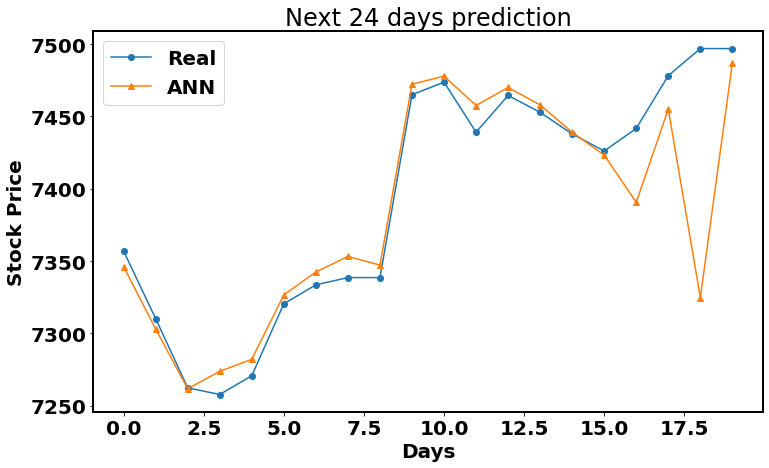

In [109]:
plt.figure(figsize=(12, 7))
# plt.plot(y_test_reg* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check_reg* target_stdev + target_mean, label = "Real",marker='o')
# plt.plot(y_check_pred_lstm* target_stdev + target_mean, label = "LSTM Prediction",marker='^')
# plt.plot(y_check_pred_arima* target_stdev + target_mean, label = "ARIMA Prediction",marker='^')
# plt.plot(y_check_pred_mlr* target_stdev + target_mean, label = "MLR Prediction",marker='^')
# plt.plot(y_check_pred_xg* target_stdev + target_mean, label = "XG boost",marker='^')
plt.plot(y_check_pred_nn* target_stdev + target_mean, label = "ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.title('Next '+str(window)+' days prediction')
plt.legend()
plt.show()

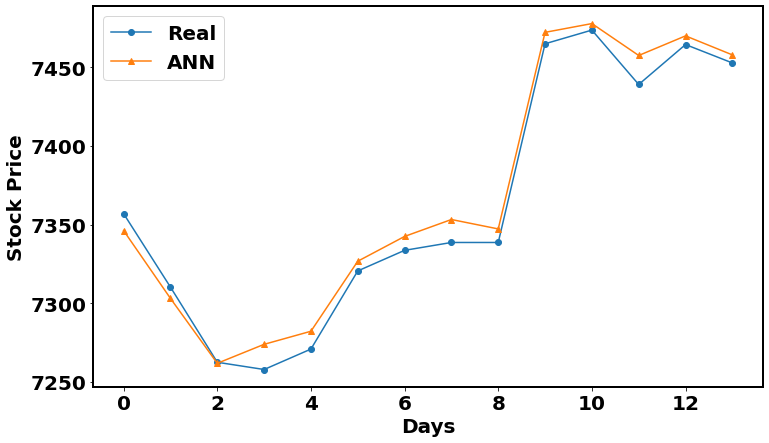

In [110]:
plt.figure(figsize=(12, 7))
# plt.plot(y_test_reg* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check_reg[:14]* target_stdev + target_mean, label = "Real",marker='o')
# plt.plot(y_check_pred_lstm* target_stdev + target_mean, label = "LSTM Prediction",marker='^')
# plt.plot(y_check_pred_arima* target_stdev + target_mean, label = "ARIMA Prediction",marker='^')
# plt.plot(y_check_pred_mlr* target_stdev + target_mean, label = "MLR Prediction",marker='^')
# plt.plot(y_check_pred_xg* target_stdev + target_mean, label = "XG boost",marker='^')
plt.plot(y_check_pred_nn[:14]* target_stdev + target_mean, label = "ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend()
plt.show()